In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import numba as nb
import json
import time
import os

PATH_ROOT = os.getcwd().replace("\\","/").replace("/notebooks","")
SEED = 42
COMPONENTS = 2

In [17]:
def write_json_to(json_dict,path):
  json_to_write = json.dumps(json_dict)
  write_file = open(path,"w")
  write_file.write(json_to_write)
  write_file.close()

def read_json_from(path):
  with open(path, "r") as read_file:
    return json.load(read_file)

def progress_report(cur_idx,total,start_time):
    percent_done = (cur_idx+1) / total
    print(f"Percent done: {percent_done}")
    time_since_start = time.time() - start_time
    print(f"Time elasped: {time_since_start}")
    print(f"Estimate finishing in: {time_since_start / (percent_done) - time_since_start}") 

In [18]:
proteomeHD_path = f"{PATH_ROOT}/data_sources/ProteomeHD/ProteomeHD_v1_1.csv"
proteomeHD_df = pd.read_csv(proteomeHD_path)
proteomeHD_simplified_protein_ids = proteomeHD_df["Simplified_protein_ID"].to_numpy()
proteomeHD_feature_matrix = proteomeHD_df.iloc[:,4:].fillna(0).to_numpy()
proteomeHD_feature_matrix_with_na = proteomeHD_df.iloc[:,4:].to_numpy()
major_simplified_idx_lookup_path = f"{PATH_ROOT}/data_sources/ProteomeHD/major_simplified_to_idx_lookup.json"
major_simplified_idx_lookup = read_json_from(major_simplified_idx_lookup_path)

pQTL_protein_path = f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_converted.csv"
pQTL_protein_df = pd.read_csv(pQTL_protein_path)
pQTL_protein_ids = pQTL_protein_df['uniprotswissprot'].to_numpy()
pQTL_protein_feature_matrix = pQTL_protein_df.iloc[:,2:].fillna(0).to_numpy()
pQTL_protein_idx_lookup_path = f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_converted_idx_lookup.json"
pQTL_protein_idx_lookup = read_json_from(pQTL_protein_idx_lookup_path)

nikolai_protein_path = f"{PATH_ROOT}/data_sources/Nikolai/Proteins-processed.csv"
nikolai_protein_df = pd.read_csv(nikolai_protein_path)
nikolai_protein_ids = nikolai_protein_df['uniprot_id']
nikolai_protein_feature_matrix = nikolai_protein_df.iloc[:,1:].fillna(0).to_numpy()
nikolai_protein_idx_lookup_path = f"{PATH_ROOT}/data_sources/Nikolai/protein_processed_lookup.json"
nikolai_protein_idx_lookup = read_json_from(nikolai_protein_idx_lookup_path)

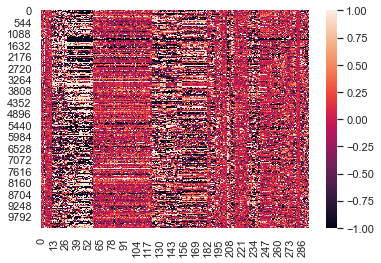

In [4]:
import seaborn as sns
sns.set()
ax = sns.heatmap(proteomeHD_feature_matrix_with_na,vmax=1,vmin=-1,robust=True)

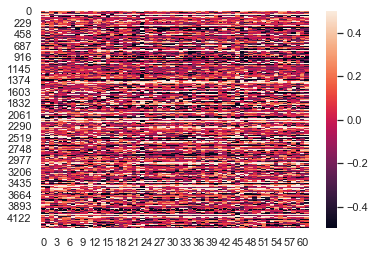

In [73]:
ax = sns.heatmap(pQTL_protein_feature_matrix,vmin=-0.5, vmax=0.5,robust=True)

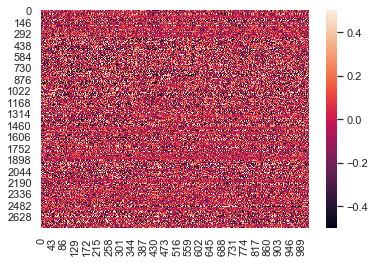

In [74]:
ax = sns.heatmap(nikolai_protein_feature_matrix,vmin=-0.5, vmax=0.5,robust=True)

# PCA

In [19]:
pca_model = PCA(n_components=COMPONENTS,random_state=SEED)

In [20]:
proteomeHD_pca = pca_model.fit(proteomeHD_feature_matrix)
proteomeHD_pca_embedding = proteomeHD_pca.transform(proteomeHD_feature_matrix)

In [35]:
pQTL_protein_pca = pca_model.fit(pQTL_protein_feature_matrix)
pQTL_protein_pca_embedding = pca_model.transform(pQTL_protein_feature_matrix)

In [36]:
nikolai_protein_pca = pca_model.fit(nikolai_protein_feature_matrix)
nikolai_protein_pca_embedding = pca_model.transform(nikolai_protein_feature_matrix)

# t-SNE

In [37]:
tsne_model = TSNE(n_components=COMPONENTS,random_state=SEED)

In [38]:
%time proteomeHD_tsne_embedding = tsne_model.fit_transform(proteomeHD_feature_matrix)

Wall time: 2min 3s


In [39]:
%time pQTL_protein_tsne_embedding = tsne_model.fit_transform(pQTL_protein_feature_matrix)

Wall time: 26.9 s


In [40]:
%time nikolai_protein_tsne_embedding = tsne_model.fit_transform(nikolai_protein_feature_matrix)

Wall time: 29.9 s


# UMAP

## with cosine as distance function

In [41]:
umap_cosine_reducer = umap.UMAP(n_components=COMPONENTS,metric='cosine',random_state=SEED)

In [42]:
%time proteomeHD_umap_cosine_embedding = umap_cosine_reducer.fit_transform(proteomeHD_feature_matrix)

Wall time: 12.9 s


In [43]:
%time pQTL_protein_umap_cosine_embedding = umap_cosine_reducer.fit_transform(pQTL_protein_feature_matrix)

Wall time: 10.5 s


In [44]:
%time nikolai_protein_umap_cosine_embedding = umap_cosine_reducer.fit_transform(nikolai_protein_feature_matrix)

Wall time: 15.7 s


## with euclidean as distance function

In [45]:
umap_euclidean_reducer = umap.UMAP(n_components=COMPONENTS,metric='euclidean',random_state=SEED)

In [46]:
%time proteomeHD_umap_euclidean_embedding = umap_euclidean_reducer.fit_transform(proteomeHD_feature_matrix)

Wall time: 15.5 s


In [47]:
%time pQTL_protein_umap_euclidean_embedding = umap_euclidean_reducer.fit_transform(pQTL_protein_feature_matrix)

Wall time: 11.1 s


In [48]:
%time nikolai_protein_umap_euclidean_embedding = umap_euclidean_reducer.fit_transform(nikolai_protein_feature_matrix)

Wall time: 15 s


## using normalized Manhattan distance as metric 

In [49]:
@nb.njit()
def normalized_manhattan_dist(vector1,vector2):
  diff = np.where(vector1>=vector2, vector1,vector2) - np.where(vector1<vector2, vector1,vector2)
  normalizing_factor = np.sum(np.maximum(np.maximum(vector1,vector2),diff))
  if normalizing_factor == 0:
    return 0
  return np.sum(diff) / normalizing_factor

umap_nman_reducer = umap.UMAP(n_components=COMPONENTS,metric=normalized_manhattan_dist,random_state=SEED)

In [50]:
%time proteomeHD_umap_nman_embedding = umap_nman_reducer.fit_transform(proteomeHD_feature_matrix)

C:\Users\hoyin\AppData\Local\Programs\Python\Python37\lib\site-packages\umap\umap_.py:1495: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


Wall time: 35.6 s


In [51]:
%time pQTL_protein_umap_nman_embedding = umap_nman_reducer.fit_transform(pQTL_protein_feature_matrix)

C:\Users\hoyin\AppData\Local\Programs\Python\Python37\lib\site-packages\umap\umap_.py:1495: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


Wall time: 14.7 s


In [52]:
%time nikolai_protein_umap_nman_embedding = umap_nman_reducer.fit_transform(nikolai_protein_feature_matrix)

C:\Users\hoyin\AppData\Local\Programs\Python\Python37\lib\site-packages\umap\umap_.py:1495: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


Wall time: 42.7 s


# Evaluate Embeddings

In [58]:
coexpression_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_coexpression_relation_lookup.json"
cooccurence_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_cooccurence_relation_lookup.json"
experiments_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_experiments_relation_lookup.json"
fusion_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_fusion_relation_lookup.json"
homology_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_homology_relation_lookup.json"
cocomplex_lookup_path = f"{PATH_ROOT}/data_sources/Corum/all_corum_complex_pairs_size_only.json"
database_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_database_relation_lookup.json"

coexpression_lookup = read_json_from(coexpression_lookup_path)
cooccurence_lookup = read_json_from(cooccurence_lookup_path)
experiments_lookup = read_json_from(experiments_lookup_path)
fusion_lookup = read_json_from(fusion_lookup_path)
homology_lookup = read_json_from(homology_lookup_path)
cocomplex_lookup = read_json_from(cocomplex_lookup_path)
database_lookup = read_json_from(database_lookup_path)

lookup_list = [coexpression_lookup,cooccurence_lookup,experiments_lookup,fusion_lookup,homology_lookup,cocomplex_lookup,database_lookup]

# kNN
def get_top_k_nearest_neighbors(vector,k,candidates,dist_function):
    k += 1
    dist_to_all = np.array(list(map(lambda x: dist_function(vector,x),candidates)))
    neighbor_indices = np.argpartition(dist_to_all, k)[0:k]
    neighbor_indices = neighbor_indices[np.argsort(dist_to_all[neighbor_indices])]
    neighbor_indices = neighbor_indices[1:]
    top_k_neighbors_dist = dist_to_all[neighbor_indices]
    return neighbor_indices,top_k_neighbors_dist

# returns report json containing relations between two proteins
def eval_relation(protein1,protein2):
    report_json = {}
    for lookup in lookup_list:
        lookup_type = lookup['relation_type']
        relation_score = float('NaN')
        try:
            relation_score = lookup[protein1][protein2]
        except KeyError:
            pass
        report_json[lookup_type] = relation_score
    return report_json

def protein_query(protein,k,dist_function,name_vector=proteomeHD_simplified_protein_ids,feature_matrix=proteomeHD_feature_matrix,lookup=major_simplified_idx_lookup):
    query_report = {}
    query_report['protein_queried'] = protein
    query_report['k'] = k
    query_report['dist_function'] = dist_function.__name__
    query_report['neighbors'] = {}
    protein_idx = lookup[protein]
    protein_vec = feature_matrix[protein_idx]
    neighbor_indices,neighbor_dists = get_top_k_nearest_neighbors(protein_vec,k,feature_matrix,dist_function)
    protein_neighbors = name_vector[neighbor_indices]
    for idx,entry in enumerate(protein_neighbors):
        query_report['neighbors'][entry] = eval_relation(protein,entry)
        query_report['neighbors'][entry]['distance'] = neighbor_dists[idx]
    return query_report

def generate_embedding_report_list(embedding,name_vector=proteomeHD_simplified_protein_ids,lookup=major_simplified_idx_lookup):
    report_list = []
    start_time = time.time()
    for idx,protein in enumerate(name_vector):
        report_list.append(protein_query(protein,5,euclidean_dist,name_vector,embedding,lookup))
        if idx % 500 == 1:
            progress_report(idx,len(name_vector),start_time)
        if idx == len(name_vector) - 1:
            print("Done")
    return report_list

def get_report_list_summary(report_list):
    summary = {}
    for report in report_list:
        protein = report['protein_queried']
        for neighbor in report['neighbors']:
            for key in report['neighbors'][neighbor]:
                if key != 'distance':
                    if report['neighbors'][neighbor][key] > 0:
                        if key not in summary:
                            summary[key] = 1
                        else:
                            summary[key] += 1
    return summary

def generate_report_json(embedding,name,source,parameters_json):
    report_json = {}
    report_list = generate_embedding_report_list(embedding)
    report_list_summary = get_report_list_summary(report_list)
    report_json['total_queries'] = len(report_list)
    report_json['queries'] = report_list
    report_json['embedding_method'] = {}
    report_json['embedding_method']['name'] = name
    report_json['embedding_method']['parameters'] = parameters_json
    report_json['source'] = source
    report_json['summary']= report_list_summary
    return report_json

def euclidean_dist(vec1,vec2):
    return np.linalg.norm(vec1-vec2)

## PCA

## proteomeHD

In [59]:
proteomeHD_pca_report_list = generate_embedding_report_list(proteomeHD_pca_embedding)
get_report_list_summary(proteomeHD_pca_report_list)

Percent done: 0.00019374212922600018
Time elasped: 0.18451237678527832
Estimate finishing in: 952.1761204004288
Percent done: 0.048629274435726046
Time elasped: 27.59401559829712
Estimate finishing in: 539.8422852407889
Percent done: 0.0970648067422261
Time elasped: 53.432968616485596
Estimate finishing in: 497.0545912916789
Percent done: 0.14550033904872614
Time elasped: 79.26995539665222
Estimate finishing in: 465.5394650824695
Percent done: 0.1939358713552262
Time elasped: 105.20808506011963
Estimate finishing in: 437.2809569356921
Percent done: 0.24237140366172624
Time elasped: 131.08410954475403
Estimate finishing in: 409.75572372083184
Percent done: 0.29080693596822627
Time elasped: 156.88487768173218
Estimate finishing in: 382.5963322811331
Percent done: 0.3392424682747263
Time elasped: 182.67302680015564
Estimate finishing in: 355.80031861903535
Percent done: 0.38767800058122637
Time elasped: 208.43758535385132
Estimate finishing in: 329.2188848130171
Percent done: 0.4361135328

{'coexpression': 446,
 'experiments': 317,
 'cocomplex': 374,
 'database': 629,
 'cooccurence': 34,
 'homology': 170,
 'fusion': 2}

## pQTL_protein

In [60]:
pca_report_list = generate_embedding_report_list(pQTL_protein_pca_embedding,pQTL_protein_ids,pQTL_protein_idx_lookup)
get_report_list_summary(pca_report_list)

Percent done: 0.00046125461254612545
Time elasped: 0.07981467247009277
Estimate finishing in: 172.95839524269104
Percent done: 0.11577490774907749
Time elasped: 11.180866718292236
Estimate finishing in: 85.39331274488532
Percent done: 0.23108856088560886
Time elasped: 22.38356041908264
Estimate finishing in: 74.47783476768615
Percent done: 0.3464022140221402
Time elasped: 33.655808448791504
Estimate finishing in: 63.50237093467052
Percent done: 0.4617158671586716
Time elasped: 44.710259199142456
Estimate finishing in: 52.12474773766159
Percent done: 0.5770295202952029
Time elasped: 55.882768869400024
Estimate finishing in: 40.96282897940833
Percent done: 0.6923431734317343
Time elasped: 67.02164816856384
Estimate finishing in: 29.782437927003386
Percent done: 0.8076568265682657
Time elasped: 78.16395473480225
Estimate finishing in: 18.614716804347538
Percent done: 0.9229704797047971
Time elasped: 89.17046904563904
Estimate finishing in: 7.442013158731498
Done


{'database': 467,
 'cocomplex': 278,
 'coexpression': 207,
 'experiments': 260,
 'cooccurence': 12,
 'homology': 84,
 'fusion': 3}

## nikolai_protein

In [61]:
nikolai_report_list = generate_embedding_report_list(nikolai_protein_pca_embedding,nikolai_protein_ids,nikolai_protein_idx_lookup)
get_report_list_summary(nikolai_report_list)

Percent done: 0.0007215007215007215
Time elasped: 0.5618529319763184
Estimate finishing in: 778.1663107872009
Percent done: 0.1810966810966811
Time elasped: 7.892436742782593
Estimate finishing in: 35.688907183498976
Percent done: 0.36147186147186144
Time elasped: 15.316253423690796
Estimate finishing in: 27.05565724544183
Percent done: 0.5418470418470418
Time elasped: 22.587979078292847
Estimate finishing in: 19.09902358817039
Percent done: 0.7222222222222222
Time elasped: 29.733686447143555
Estimate finishing in: 11.436033248901367
Percent done: 0.9025974025974026
Time elasped: 36.90148687362671
Estimate finishing in: 3.982174842477704
Done


{'coexpression': 99,
 'experiments': 74,
 'database': 150,
 'cocomplex': 93,
 'homology': 23}

## tSNE

## proteomeHD

In [62]:
tsne_report_list = generate_embedding_report_list(proteomeHD_tsne_embedding)
get_report_list_summary(tsne_report_list)

Percent done: 0.00019374212922600018
Time elasped: 0.15812063217163086
Estimate finishing in: 815.981522321701
Percent done: 0.048629274435726046
Time elasped: 25.913247108459473
Estimate finishing in: 506.9601590680886
Percent done: 0.0970648067422261
Time elasped: 51.846505641937256
Estimate finishing in: 482.29668571706304
Percent done: 0.14550033904872614
Time elasped: 77.76718068122864
Estimate finishing in: 456.713915305671
Percent done: 0.1939358713552262
Time elasped: 103.92044067382812
Estimate finishing in: 431.92906435910277
Percent done: 0.24237140366172624
Time elasped: 131.67319536209106
Estimate finishing in: 411.5971466534429
Percent done: 0.29080693596822627
Time elasped: 159.1019332408905
Estimate finishing in: 388.0030823639439
Percent done: 0.3392424682747263
Time elasped: 186.06938648223877
Estimate finishing in: 362.4155583082098
Percent done: 0.38767800058122637
Time elasped: 213.86052441596985
Estimate finishing in: 337.7842016075326
Percent done: 0.436113532887

{'database': 1894,
 'coexpression': 1276,
 'experiments': 1263,
 'cooccurence': 133,
 'homology': 486,
 'cocomplex': 1223,
 'fusion': 9}

## pQTL_protein

In [63]:
pQTL_protein_tsne_report_list = generate_embedding_report_list(pQTL_protein_tsne_embedding,pQTL_protein_ids,pQTL_protein_idx_lookup)
get_report_list_summary(pQTL_protein_tsne_report_list)

Percent done: 0.00046125461254612545
Time elasped: 0.06290030479431152
Estimate finishing in: 136.30496048927307
Percent done: 0.11577490774907749
Time elasped: 11.02148962020874
Estimate finishing in: 84.1760780953791
Percent done: 0.23108856088560886
Time elasped: 22.311326503753662
Estimate finishing in: 74.23748758833803
Percent done: 0.3464022140221402
Time elasped: 33.23995351791382
Estimate finishing in: 62.717728541789455
Percent done: 0.4617158671586716
Time elasped: 44.42125058174133
Estimate finishing in: 51.78781161727487
Percent done: 0.5770295202952029
Time elasped: 55.27763748168945
Estimate finishing in: 40.519259449008175
Percent done: 0.6923431734317343
Time elasped: 66.10934782028198
Estimate finishing in: 29.377038638326496
Percent done: 0.8076568265682657
Time elasped: 77.15486145019531
Estimate finishing in: 18.374401613210424
Percent done: 0.9229704797047971
Time elasped: 88.25536918640137
Estimate finishing in: 7.365640506811104
Done


{'database': 2056,
 'experiments': 1540,
 'cocomplex': 1485,
 'homology': 295,
 'coexpression': 939,
 'cooccurence': 82,
 'fusion': 8}

## nikolai_protein

In [64]:
nikolai_protein_tsne_report_list = generate_embedding_report_list(nikolai_protein_tsne_embedding,nikolai_protein_ids,nikolai_protein_idx_lookup)
get_report_list_summary(nikolai_protein_tsne_report_list)

Percent done: 0.0007215007215007215
Time elasped: 0.05086350440979004
Estimate finishing in: 70.4459536075592
Percent done: 0.1810966810966811
Time elasped: 7.308593034744263
Estimate finishing in: 33.048817109301744
Percent done: 0.36147186147186144
Time elasped: 14.752177476882935
Estimate finishing in: 26.05923566275728
Percent done: 0.5418470418470418
Time elasped: 22.050123691558838
Estimate finishing in: 18.64424573121154
Percent done: 0.7222222222222222
Time elasped: 29.324769496917725
Estimate finishing in: 11.278757498814507
Percent done: 0.9025974025974026
Time elasped: 36.601125955581665
Estimate finishing in: 3.949761793767806
Done


{'coexpression': 89,
 'database': 134,
 'cocomplex': 72,
 'homology': 22,
 'experiments': 70}

## umap

## proteomeHD (cosine)

In [65]:
umap_cosine_report_list = generate_embedding_report_list(proteomeHD_umap_cosine_embedding)
get_report_list_summary(umap_cosine_report_list)

Percent done: 0.00019374212922600018
Time elasped: 0.14460325241088867
Estimate finishing in: 746.225084066391
Percent done: 0.048629274435726046
Time elasped: 26.514302015304565
Estimate finishing in: 518.719044008578
Percent done: 0.0970648067422261
Time elasped: 52.62258195877075
Estimate finishing in: 489.5160543290441
Percent done: 0.14550033904872614
Time elasped: 78.93914127349854
Estimate finishing in: 463.5966479184625
Percent done: 0.1939358713552262
Time elasped: 104.95449733734131
Estimate finishing in: 436.2269592127957
Percent done: 0.24237140366172624
Time elasped: 131.13924956321716
Estimate finishing in: 409.9280858648767
Percent done: 0.29080693596822627
Time elasped: 157.33214139938354
Estimate finishing in: 383.6870776765113
Percent done: 0.3392424682747263
Time elasped: 183.39674544334412
Estimate finishing in: 357.209937369803
Percent done: 0.38767800058122637
Time elasped: 211.19371914863586
Estimate finishing in: 333.5720886403117
Percent done: 0.436113532887726

{'database': 1164,
 'coexpression': 706,
 'homology': 244,
 'cooccurence': 58,
 'experiments': 578,
 'cocomplex': 627,
 'fusion': 4}

## pQTL_protein (cosine)

In [66]:
pQTL_protein_umap_cosine_report_list = generate_embedding_report_list(pQTL_protein_umap_cosine_embedding,pQTL_protein_ids,pQTL_protein_idx_lookup)
get_report_list_summary(pQTL_protein_umap_cosine_report_list)

Percent done: 0.00046125461254612545
Time elasped: 0.06907200813293457
Estimate finishing in: 149.6790416240692
Percent done: 0.11577490774907749
Time elasped: 11.324766159057617
Estimate finishing in: 86.49233755742411
Percent done: 0.23108856088560886
Time elasped: 22.60331702232361
Estimate finishing in: 75.20904087068554
Percent done: 0.3464022140221402
Time elasped: 33.63514423370361
Estimate finishing in: 63.463381330436775
Percent done: 0.4617158671586716
Time elasped: 44.4938280582428
Estimate finishing in: 51.8724249190503
Percent done: 0.5770295202952029
Time elasped: 55.45306158065796
Estimate finishing in: 40.64784769741276
Percent done: 0.6923431734317343
Time elasped: 66.44489526748657
Estimate finishing in: 29.526145998276846
Percent done: 0.8076568265682657
Time elasped: 77.38013887405396
Estimate finishing in: 18.42805134807567
Percent done: 0.9229704797047971
Time elasped: 88.44408178329468
Estimate finishing in: 7.381390133838181
Done


{'cocomplex': 1169,
 'database': 1514,
 'experiments': 1128,
 'coexpression': 647,
 'cooccurence': 39,
 'homology': 190,
 'fusion': 2}

## nikolai_protein (cosine)

In [67]:
nikolai_protein_umap_cosine_report_list = generate_embedding_report_list(nikolai_protein_umap_cosine_embedding,nikolai_protein_ids,nikolai_protein_idx_lookup)
get_report_list_summary(nikolai_protein_umap_cosine_report_list)

Percent done: 0.0007215007215007215
Time elasped: 0.04491400718688965
Estimate finishing in: 62.20589995384216
Percent done: 0.1810966810966811
Time elasped: 7.286037921905518
Estimate finishing in: 32.946824865987104
Percent done: 0.36147186147186144
Time elasped: 14.571917295455933
Estimate finishing in: 25.740811988979047
Percent done: 0.5418470418470418
Time elasped: 21.935187816619873
Estimate finishing in: 18.547062934159285
Percent done: 0.7222222222222222
Time elasped: 29.493530750274658
Estimate finishing in: 11.343665673182564
Percent done: 0.9025974025974026
Time elasped: 36.81370687484741
Estimate finishing in: 3.972702180738928
Done


{'coexpression': 123,
 'database': 178,
 'cocomplex': 107,
 'homology': 33,
 'experiments': 101,
 'cooccurence': 6}

## proteomeHD (euclidean)

In [68]:
umap_euclidean_report_list = generate_embedding_report_list(proteomeHD_umap_euclidean_embedding)
get_report_list_summary(umap_euclidean_report_list)

Percent done: 0.00019374212922600018
Time elasped: 0.1445937156677246
Estimate finishing in: 746.1758697032928
Percent done: 0.048629274435726046
Time elasped: 26.675163745880127
Estimate finishing in: 521.8661018890214
Percent done: 0.0970648067422261
Time elasped: 53.16603946685791
Estimate finishing in: 494.5715108488848
Percent done: 0.14550033904872614
Time elasped: 79.56639122962952
Estimate finishing in: 467.28038417880293
Percent done: 0.1939358713552262
Time elasped: 105.63333797454834
Estimate finishing in: 439.04845418891944
Percent done: 0.24237140366172624
Time elasped: 132.22415041923523
Estimate finishing in: 413.3193766701993
Percent done: 0.29080693596822627
Time elasped: 158.34505319595337
Estimate finishing in: 386.15727330032473
Percent done: 0.3392424682747263
Time elasped: 185.04181933403015
Estimate finishing in: 360.4141204104568
Percent done: 0.38767800058122637
Time elasped: 212.26677441596985
Estimate finishing in: 335.2669368024351
Percent done: 0.4361135328

{'experiments': 754,
 'cocomplex': 796,
 'database': 1221,
 'coexpression': 928,
 'cooccurence': 62,
 'homology': 266,
 'fusion': 4}

## pQTL_protein (euclidean)

In [69]:
pQTL_protein_umap_euclidean_report_list = generate_embedding_report_list(pQTL_protein_umap_euclidean_embedding,pQTL_protein_ids,pQTL_protein_idx_lookup)
get_report_list_summary(pQTL_protein_umap_euclidean_report_list)

Percent done: 0.00046125461254612545
Time elasped: 0.07250642776489258
Estimate finishing in: 157.12142896652222
Percent done: 0.11577490774907749
Time elasped: 11.226674318313599
Estimate finishing in: 85.7431660087935
Percent done: 0.23108856088560886
Time elasped: 22.555443286895752
Estimate finishing in: 75.0497484216671
Percent done: 0.3464022140221402
Time elasped: 33.96697926521301
Estimate finishing in: 64.08949350040858
Percent done: 0.4617158671586716
Time elasped: 45.09168338775635
Estimate finishing in: 52.56942508842323
Percent done: 0.5770295202952029
Time elasped: 56.23937511444092
Estimate finishing in: 41.224226202991474
Percent done: 0.6923431734317343
Time elasped: 67.16785311698914
Estimate finishing in: 29.847407081300304
Percent done: 0.8076568265682657
Time elasped: 78.1871554851532
Estimate finishing in: 18.620242054431117
Percent done: 0.9229704797047971
Time elasped: 89.20316982269287
Estimate finishing in: 7.444742309040336
Done


{'database': 1140,
 'homology': 132,
 'cocomplex': 762,
 'experiments': 754,
 'coexpression': 423,
 'cooccurence': 34,
 'fusion': 2}

## nikolai_protein

In [70]:
nikolai_protein_umap_euclidean_report_list = generate_embedding_report_list(nikolai_protein_umap_euclidean_embedding,nikolai_protein_ids,nikolai_protein_idx_lookup)
get_report_list_summary(nikolai_protein_umap_euclidean_report_list)

Percent done: 0.0007215007215007215
Time elasped: 0.049865007400512695
Estimate finishing in: 69.06303524971008
Percent done: 0.1810966810966811
Time elasped: 7.410686492919922
Estimate finishing in: 33.51047477874148
Percent done: 0.36147186147186144
Time elasped: 14.749349117279053
Estimate finishing in: 26.054239458666594
Percent done: 0.5418470418470418
Time elasped: 22.01296091079712
Estimate finishing in: 18.612823140287844
Percent done: 0.7222222222222222
Time elasped: 29.174376487731934
Estimate finishing in: 11.22091403374305
Percent done: 0.9025974025974026
Time elasped: 36.43917965888977
Estimate finishing in: 3.9322855747003373
Done


{'coexpression': 74,
 'cocomplex': 83,
 'experiments': 83,
 'homology': 15,
 'database': 130,
 'cooccurence': 2}

## proteomeHD (nman)

In [71]:
umap_nman_report_list = generate_embedding_report_list(proteomeHD_umap_nman_embedding)
get_report_list_summary(umap_nman_report_list)

Percent done: 0.00019374212922600018
Time elasped: 0.13961338996887207
Estimate finishing in: 720.4748989343643
Percent done: 0.048629274435726046
Time elasped: 26.64257311820984
Estimate finishing in: 521.2285071592407
Percent done: 0.0970648067422261
Time elasped: 52.83141779899597
Estimate finishing in: 491.45872784874393
Percent done: 0.14550033904872614
Time elasped: 79.65739607810974
Estimate finishing in: 467.8148407490054
Percent done: 0.1939358713552262
Time elasped: 106.25459909439087
Estimate finishing in: 441.6306289033099
Percent done: 0.24237140366172624
Time elasped: 132.5537087917328
Estimate finishing in: 414.34954294969714
Percent done: 0.29080693596822627
Time elasped: 158.78644347190857
Estimate finishing in: 387.23369508922144
Percent done: 0.3392424682747263
Time elasped: 185.14999961853027
Estimate finishing in: 360.6248279263265
Percent done: 0.38767800058122637
Time elasped: 211.31688523292542
Estimate finishing in: 333.76662457704185
Percent done: 0.4361135328

{'database': 1652,
 'coexpression': 869,
 'cocomplex': 1158,
 'experiments': 1060,
 'homology': 316,
 'cooccurence': 69,
 'fusion': 6}

## pQTL_protein (nman)

In [72]:
pQTL_protein_umap_nman_report_list = generate_embedding_report_list(pQTL_protein_umap_nman_embedding,pQTL_protein_ids,pQTL_protein_idx_lookup)
get_report_list_summary(pQTL_protein_umap_nman_report_list)

Percent done: 0.00046125461254612545
Time elasped: 0.06983757019042969
Estimate finishing in: 151.33801460266113
Percent done: 0.11577490774907749
Time elasped: 11.439560413360596
Estimate finishing in: 87.36907295781778
Percent done: 0.23108856088560886
Time elasped: 22.55453133583069
Estimate finishing in: 75.04671404556838
Percent done: 0.3464022140221402
Time elasped: 33.72457504272461
Estimate finishing in: 63.63212095278398
Percent done: 0.4617158671586716
Time elasped: 44.67475366592407
Estimate finishing in: 52.083354173959435
Percent done: 0.5770295202952029
Time elasped: 55.96866035461426
Estimate finishing in: 41.025788605260814
Percent done: 0.6923431734317343
Time elasped: 66.86605787277222
Estimate finishing in: 29.713298201958068
Percent done: 0.8076568265682657
Time elasped: 77.83383846282959
Estimate finishing in: 18.536099736721837
Percent done: 0.9229704797047971
Time elasped: 88.75250029563904
Estimate finishing in: 7.407130209581069
Done


{'database': 1440,
 'cocomplex': 1070,
 'experiments': 1050,
 'coexpression': 723,
 'homology': 145,
 'cooccurence': 36,
 'fusion': 2}

In [73]:
nikolai_protein_umap_nman_report_list = generate_embedding_report_list(nikolai_protein_umap_nman_embedding,nikolai_protein_ids,nikolai_protein_idx_lookup)
get_report_list_summary(nikolai_protein_umap_nman_report_list)

Percent done: 0.0007215007215007215
Time elasped: 0.047870635986328125
Estimate finishing in: 66.30083084106445
Percent done: 0.1810966810966811
Time elasped: 7.329326391220093
Estimate finishing in: 33.14257153001915
Percent done: 0.36147186147186144
Time elasped: 14.718669652938843
Estimate finishing in: 26.00004519531113
Percent done: 0.5418470418470418
Time elasped: 21.999926328659058
Estimate finishing in: 18.601801889079233
Percent done: 0.7222222222222222
Time elasped: 29.300076007843018
Estimate finishing in: 11.269260003016548
Percent done: 0.9025974025974026
Time elasped: 36.83137035369873
Estimate finishing in: 3.97460831155022
Done


{'coexpression': 112,
 'experiments': 83,
 'cocomplex': 96,
 'database': 160,
 'homology': 30,
 'cooccurence': 4}

# Original Dimensions

# proteomeHD

In [74]:
proteomeHD_og_report_list = generate_embedding_report_list(proteomeHD_feature_matrix)
get_report_list_summary(proteomeHD_og_report_list)

Percent done: 0.00019374212922600018
Time elasped: 0.2293872833251953
Estimate finishing in: 1183.7530755996704
Percent done: 0.048629274435726046
Time elasped: 42.24728178977966
Estimate finishing in: 826.5150487199724
Percent done: 0.0970648067422261
Time elasped: 85.5257318019867
Estimate finishing in: 795.5941578106965
Percent done: 0.14550033904872614
Time elasped: 127.34926724433899
Estimate finishing in: 747.9013890561347
Percent done: 0.1939358713552262
Time elasped: 171.5900993347168
Estimate finishing in: 713.187420861228
Percent done: 0.24237140366172624
Time elasped: 213.76750016212463
Estimate finishing in: 668.215674967217
Percent done: 0.29080693596822627
Time elasped: 257.354572057724
Estimate finishing in: 627.6125323233169
Percent done: 0.3392424682747263
Time elasped: 299.8179659843445
Estimate finishing in: 583.9686881722484
Percent done: 0.38767800058122637
Time elasped: 343.2800726890564
Estimate finishing in: 542.197236248757
Percent done: 0.4361135328877264
Time

{'experiments': 1298,
 'cocomplex': 1305,
 'database': 1945,
 'homology': 537,
 'coexpression': 1472,
 'cooccurence': 158,
 'fusion': 6}

# pQTL_protein

In [75]:
pQTL_protein_og_report_list = generate_embedding_report_list(pQTL_protein_feature_matrix,pQTL_protein_ids,pQTL_protein_idx_lookup)
get_report_list_summary(pQTL_protein_og_report_list)

Percent done: 0.00046125461254612545
Time elasped: 0.08177351951599121
Estimate finishing in: 177.20321679115295
Percent done: 0.11577490774907749
Time elasped: 15.133320808410645
Estimate finishing in: 115.57998402280163
Percent done: 0.23108856088560886
Time elasped: 30.51510262489319
Estimate finishing in: 101.53428358422545
Percent done: 0.3464022140221402
Time elasped: 45.54475474357605
Estimate finishing in: 85.93464377050233
Percent done: 0.4617158671586716
Time elasped: 64.28420233726501
Estimate finishing in: 74.9447194081801
Percent done: 0.5770295202952029
Time elasped: 80.4576325416565
Estimate finishing in: 58.97653800215747
Percent done: 0.6923431734317343
Time elasped: 96.1471779346466
Estimate finishing in: 42.724961813730374
Percent done: 0.8076568265682657
Time elasped: 111.31889653205872
Estimate finishing in: 26.51055388570444
Percent done: 0.9229704797047971
Time elasped: 127.63255643844604
Estimate finishing in: 10.651992466377067
Done


{'coexpression': 1264,
 'database': 2563,
 'homology': 342,
 'experiments': 1876,
 'cocomplex': 1839,
 'cooccurence': 100,
 'fusion': 7}

# nikolai_protein

In [76]:
nikolai_protein_og_report_list = generate_embedding_report_list(nikolai_protein_feature_matrix,nikolai_protein_ids,nikolai_protein_idx_lookup)
get_report_list_summary(nikolai_protein_og_report_list)

Percent done: 0.0007215007215007215
Time elasped: 0.13065004348754883
Estimate finishing in: 180.95031023025513
Percent done: 0.1810966810966811
Time elasped: 28.51600193977356
Estimate finishing in: 128.94686136112745
Percent done: 0.36147186147186144
Time elasped: 56.49781346321106
Estimate finishing in: 99.80152677633092
Percent done: 0.5418470418470418
Time elasped: 85.31966948509216
Estimate finishing in: 72.14113198806064
Percent done: 0.7222222222222222
Time elasped: 114.33526301383972
Estimate finishing in: 43.97510115916913
Percent done: 0.9025974025974026
Time elasped: 143.1602554321289
Estimate finishing in: 15.448948427927576
Done


{'database': 49,
 'cocomplex': 9,
 'homology': 17,
 'experiments': 15,
 'coexpression': 4,
 'cooccurence': 2}

# Autoencoded

## ProteomeHD

In [77]:
proteomeHD_autoencoder_embedding_path = f"{PATH_ROOT}/embeddings/autoencoder/proteomeHD_autoencoder_embedding.npy"
proteomeHD_autoencoder_embedding = np.load(proteomeHD_autoencoder_embedding_path)
proteomeHD_autoencoded_report_list = generate_embedding_report_list(proteomeHD_autoencoder_embedding)
get_report_list_summary(proteomeHD_autoencoded_report_list)

Percent done: 0.00019374212922600018
Time elasped: 0.15059471130371094
Estimate finishing in: 777.1440076828003
Percent done: 0.048629274435726046
Time elasped: 28.807772874832153
Estimate finishing in: 563.5879231149933
Percent done: 0.0970648067422261
Time elasped: 56.94027376174927
Estimate finishing in: 529.6809298735178
Percent done: 0.14550033904872614
Time elasped: 85.11912226676941
Estimate finishing in: 499.8906641246158
Percent done: 0.1939358713552262
Time elasped: 112.55022168159485
Estimate finishing in: 467.79739990636904
Percent done: 0.24237140366172624
Time elasped: 141.25679183006287
Estimate finishing in: 441.5545039580022
Percent done: 0.29080693596822627
Time elasped: 171.26138973236084
Estimate finishing in: 417.6564404499047
Percent done: 0.3392424682747263
Time elasped: 200.39667105674744
Estimate finishing in: 390.3214429691817
Percent done: 0.38767800058122637
Time elasped: 229.84544277191162
Estimate finishing in: 363.0317450677795
Percent done: 0.43611353288

{'homology': 134,
 'database': 644,
 'coexpression': 426,
 'experiments': 307,
 'cocomplex': 352,
 'cooccurence': 27,
 'fusion': 2}

## pQTL_protein

In [78]:
pQTL_autoencoder_embedding_path = f"{PATH_ROOT}/embeddings/autoencoder/pQTL_autoencoder_embedding.npy"
pQTL_autoencoder_embedding = np.load(pQTL_autoencoder_embedding_path)
pQTL_protein_autoencoded_report_list = generate_embedding_report_list(pQTL_autoencoder_embedding,pQTL_protein_ids,pQTL_protein_idx_lookup)
get_report_list_summary(pQTL_protein_autoencoded_report_list)

Percent done: 0.00046125461254612545
Time elasped: 0.06590151786804199
Estimate finishing in: 142.808589220047
Percent done: 0.11577490774907749
Time elasped: 12.548702239990234
Estimate finishing in: 95.8400884225549
Percent done: 0.23108856088560886
Time elasped: 24.331027030944824
Estimate finishing in: 80.95772866384236
Percent done: 0.3464022140221402
Time elasped: 36.414074182510376
Estimate finishing in: 68.70671520188709
Percent done: 0.4617158671586716
Time elasped: 48.115450382232666
Estimate finishing in: 56.09463596010542
Percent done: 0.5770295202952029
Time elasped: 59.68809413909912
Estimate finishing in: 43.752184113152595
Percent done: 0.6923431734317343
Time elasped: 70.91138553619385
Estimate finishing in: 31.510922153658427
Percent done: 0.8076568265682657
Time elasped: 82.74442267417908
Estimate finishing in: 19.70555354376509
Percent done: 0.9229704797047971
Time elasped: 94.90609812736511
Estimate finishing in: 7.920698844212879
Done


{'database': 605,
 'experiments': 341,
 'cocomplex': 357,
 'homology': 94,
 'coexpression': 288,
 'cooccurence': 15,
 'fusion': 1}

## nikolai_protein

In [79]:
nikolai_autoencoder_embedding_path = f"{PATH_ROOT}/embeddings/autoencoder/nikolai_autoencoder_embedding.npy"
nikolai_autoencoder_embedding = np.load(nikolai_autoencoder_embedding_path)
nikolai_protein_autoencoded_report_list = generate_embedding_report_list(nikolai_autoencoder_embedding,nikolai_protein_ids,nikolai_protein_idx_lookup)
get_report_list_summary(nikolai_protein_autoencoded_report_list)

Percent done: 0.0007215007215007215
Time elasped: 0.040895938873291016
Estimate finishing in: 56.64087533950806
Percent done: 0.1810966810966811
Time elasped: 8.563498973846436
Estimate finishing in: 38.72339177416615
Percent done: 0.36147186147186144
Time elasped: 16.819957971572876
Estimate finishing in: 29.71190180607185
Percent done: 0.5418470418470418
Time elasped: 25.04178762435913
Estimate finishing in: 21.17381510182164
Percent done: 0.7222222222222222
Time elasped: 33.33094024658203
Estimate finishing in: 12.819592402531548
Percent done: 0.9025974025974026
Time elasped: 41.92581033706665
Estimate finishing in: 4.524368021985609
Done


{'coexpression': 87,
 'cocomplex': 93,
 'database': 115,
 'homology': 19,
 'experiments': 56}

# Uniform Embedding

In [80]:
xy_min = [-1, -1]
xy_max = [1, 1]
proteomeHD_uniform_embedding = np.random.uniform(low=xy_min, high=xy_max, size=(len(proteomeHD_feature_matrix),2))
pQTL_uniform_embedding = np.random.uniform(low=xy_min, high=xy_max, size=(len(pQTL_protein_feature_matrix),2))
nikolai_uniform_embedding = np.random.uniform(low=xy_min, high=xy_max, size=(len(nikolai_protein_feature_matrix),2))

## proteomeHD

In [81]:
proteomeHD_uniform_report_list = generate_embedding_report_list(proteomeHD_uniform_data)
get_report_list_summary(proteomeHD_uniform_report_list)

Percent done: 0.00019374212922600018
Time elasped: 0.17430734634399414
Estimate finishing in: 899.5130608081818
Percent done: 0.048629274435726046
Time elasped: 28.375370502471924
Estimate finishing in: 555.128513356129
Percent done: 0.0970648067422261
Time elasped: 55.43517446517944
Estimate finishing in: 515.6799013871632
Percent done: 0.14550033904872614
Time elasped: 81.64519333839417
Estimate finishing in: 479.4888484939913
Percent done: 0.1939358713552262
Time elasped: 107.76556539535522
Estimate finishing in: 447.9107241032722
Percent done: 0.24237140366172624
Time elasped: 133.84721755981445
Estimate finishing in: 418.3929210772617
Percent done: 0.29080693596822627
Time elasped: 160.19252824783325
Estimate finishing in: 390.66272461771734
Percent done: 0.3392424682747263
Time elasped: 186.5770547389984
Estimate finishing in: 363.4043661835261
Percent done: 0.38767800058122637
Time elasped: 212.5248372554779
Estimate finishing in: 335.67453680456674
Percent done: 0.4361135328877

{'database': 136,
 'cocomplex': 44,
 'homology': 28,
 'experiments': 25,
 'coexpression': 22,
 'cooccurence': 1}

## pQTL_protein

In [82]:
pQTL_protein_uniform_report_list = generate_embedding_report_list(pQTL_uniform_embedding,pQTL_protein_ids,pQTL_protein_idx_lookup)
get_report_list_summary(pQTL_protein_uniform_report_list)

Percent done: 0.00046125461254612545
Time elasped: 0.05885171890258789
Estimate finishing in: 127.53167486190796
Percent done: 0.11577490774907749
Time elasped: 10.95895528793335
Estimate finishing in: 83.69847524688538
Percent done: 0.23108856088560886
Time elasped: 22.036702394485474
Estimate finishing in: 73.32371834652152
Percent done: 0.3464022140221402
Time elasped: 33.006431102752686
Estimate finishing in: 62.27711434434161
Percent done: 0.4617158671586716
Time elasped: 43.979740858078
Estimate finishing in: 51.273084496880145
Percent done: 0.5770295202952029
Time elasped: 54.93167591094971
Estimate finishing in: 40.26566491633963
Percent done: 0.6923431734317343
Time elasped: 66.64767599105835
Estimate finishing in: 29.6162557535216
Percent done: 0.8076568265682657
Time elasped: 78.81606650352478
Estimate finishing in: 18.770016979994196
Percent done: 0.9229704797047971
Time elasped: 90.23677039146423
Estimate finishing in: 7.531004825274621
Done


{'database': 183,
 'experiments': 54,
 'coexpression': 44,
 'cocomplex': 77,
 'homology': 17,
 'fusion': 3,
 'cooccurence': 2}

## nikolai_protein

In [83]:
nikolai_protein_uniform_report_list = generate_embedding_report_list(nikolai_uniform_embedding,nikolai_protein_ids,nikolai_protein_idx_lookup)
get_report_list_summary(nikolai_protein_uniform_report_list)

Percent done: 0.0007215007215007215
Time elasped: 0.04890561103820801
Estimate finishing in: 67.73427128791809
Percent done: 0.1810966810966811
Time elasped: 7.338407039642334
Estimate finishing in: 33.183633426271115
Percent done: 0.36147186147186144
Time elasped: 14.629880666732788
Estimate finishing in: 25.843202375366303
Percent done: 0.5418470418470418
Time elasped: 21.841079235076904
Estimate finishing in: 18.467490431789393
Percent done: 0.7222222222222222
Time elasped: 29.153780460357666
Estimate finishing in: 11.212992484752952
Percent done: 0.9025974025974026
Time elasped: 36.345754623413086
Estimate finishing in: 3.92220373633954
Done


{'database': 86,
 'coexpression': 33,
 'experiments': 26,
 'cocomplex': 37,
 'homology': 7}